In [1]:
import numpy as np
import projectLib as lib
import matplotlib.pyplot as plt
import inspect

# set highest rating
K = 5
F = 3
eps=0.1

def softmax(x):
    # Numerically stable softmax function
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def ratingsPerMovie(training):
    movies = [x[0] for x in training]
    u_movies = np.unique(movies).tolist()
    return np.array([[i, movie, len([x for x in training if x[0] == movie])] for i, movie in enumerate(u_movies)])

def getV(ratingsForUser):
    # ratingsForUser is obtained from the ratings for user library
    # you should return a binary matrix ret of size m x K, where m is the number of movies
    #   that the user has seen. ret[i][k] = 1 if the user
    #   has rated movie ratingsForUser[i, 0] with k stars
    #   otherwise it is 0
    ret = np.zeros((len(ratingsForUser), K))
    for i in range(len(ratingsForUser)):
        ret[i, ratingsForUser[i, 1]-1] = 1.0
    return ret

def getInitialWeights(m, F, K):
    # m is the number of visible units
    # F is the number of hidden units
    # K is the highest rating (fixed to 5 here)
    return np.random.normal(0, 0.1, (m, F, K))

In [2]:
training = lib.getTrainingData()
ratingsForUser1 = lib.getRatingsForUser(1, training)

In [3]:
# ratingsPerMovie(training)
v = getV(ratingsForUser1)
# v.shape
w = getInitialWeights(v.shape[0],F,5)

In [4]:
trStats = lib.getUsefulStats(training)
W = getInitialWeights(trStats["n_movies"], F, K)

In [5]:
def sig(x):
    ### TO IMPLEMENT ###
    # x is a real vector of size n
    # ret should be a vector of size n where ret_i = sigmoid(x_i)
    return 1/(1+np.exp(-x))

def visibleToHiddenVec(v, w, hid_bias):
    ### TO IMPLEMENT ###
    # v is a matrix of size m x 5. Each row is a binary vector representing a rating
    #    OR a probability distribution over the rating
    # w is a list of matrices of size m x F x 5
    # ret should be a vector of size F
    m,f,K=w.shape
    output=list()
    for i in range(f):
        summ=0
        for k in range(K):
            for j in range(m):
                summ+=v[j,k]*w[j,i,k]
        output.append(summ)

    return sig(np.array(output)+hid_bias)
    

def hiddenToVisible(h, w, vis_bias):
    ### TO IMPLEMENT ###
    # h is a binary vector of size F
    # w is an array of size m x F x 5
    # ret should be a matrix of size m x 5, where m
    #   is the number of movies the user has seen.
    #   Remember that we do not reconstruct movies that the user
    #   has not rated! (where reconstructing means getting a distribution
    #   over possible ratings).
    #   We only do so when we predict the rating a user would have given to a movie.
#     print(w.shape)
    output=w[:,0,:]*h[0]
    m,f,k=w.shape
    for i in range(1,f):
        output+=w[:,i,:]*h[i]
    return sig(output+vis_bias)

def probProduct(v, p):
    # v is a matrix of size m x 5
    # p is a vector of size F, activation of the hidden units
    # returns the gradient for visible input v and hidden activations p
    ret = np.zeros((v.shape[0], p.size, v.shape[1]))
    for i in range(v.shape[0]):
        for j in range(p.size):
            for k in range(v.shape[1]):
                ret[i, j, k] = v[i, k] * p[j]
    return ret

def sample(p):
    # p is a vector of real numbers between 0 and 1
    # ret is a vector of same size as p, where ret_i = Ber(p_i)
    # In other word we sample from a Bernouilli distribution with
    # parameter p_i to obtain ret_i
    samples = np.random.random(p.size)
    return np.array(samples <= p, dtype=int)

def getPredictedDistribution(v, w, wq,vis_bias,hid_bias):
    ### TO IMPLEMENT ###
    # This function returns a distribution over the ratings for movie q, if user data is v
    # v is the dataset of the user we are predicting the movie for
    #   It is a m x 5 matrix, where m is the number of movies in the
    #   dataset of this user.
    # w is the weights array for the current user, of size m x F x 5
    # wq is the weight matrix of size F x 5 for movie q
    #   If W is the whole weights array, then wq = W[q, :, :]
    # You will need to perform the same steps done in the learning/unlearning:
    #   - Propagate the user input to the hidden units
    #   - Sample the state of the hidden units
    #   - Backpropagate these hidden states to obtain
    #       the distribution over the movie whose associated weights are wq
    # ret is a vector of size 5
    m,f,K=w.shape
    p_learn = visibleToHiddenVec(v,w,hid_bias)
    PG = probProduct(v, p_learn)
    hidden_activations = sample(p_learn)
    v_negative = hiddenToVisible(hidden_activations, wq.reshape(1,wq.shape[0],wq.shape[1]),vis_bias)

    return v_negative.reshape(5)

def predictRatingMax(ratingDistribution):
    ### TO IMPLEMENT ###
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the one with the highest probability
    max_indices = np.where(ratingDistribution == np.amax(ratingDistribution))[0]
    if max_indices.shape[0] == 1:
        result = max_indices.item()
    else:
        result = 2
    return result+1

def predictRatingMean(ratingDistribution):
    ### TO IMPLEMENT ###
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the expectation over ratingDistribution
    normalized = [i/sum(ratingDistribution) for i in ratingDistribution]
    result = 0 
    for k in range(ratingDistribution.shape[0]):
        result += normalized[k]*(k+1)
    return result

def predictRatingExp(ratingDistribution):
    ### TO IMPLEMENT ###
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the expectation over
    # the softmax applied to ratingDistribution
    softmax = np.exp(ratingDistribution)/sum(np.exp(ratingDistribution))
#     print(softmax)
    result = 0 
    for k in range(len(ratingDistribution)):
        result += softmax[k]*(k+1)
#         print (result)
    return result

def predictMovieForUser(q, user, W, training,vis_bias,hid_bias, predictType="exp"):
    # movie is movie idx
    # user is user ID
    # type can be "max" or "exp"
    ratingsForUser = lib.getRatingsForUser(user, training)
    v = getV(ratingsForUser)
#     print(np.where(ratingsForUser[:,0]==q))
    ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], W[q, :, :],vis_bias[q],hid_bias)#[np.where(ratingsForUser[:,0]==q)[0][0]]
    if predictType == "max":
        return predictRatingMax(ratingDistribution)
    elif predictType == "mean":
        return predictRatingMean(ratingDistribution)
    else:
        return predictRatingExp(ratingDistribution)

def predict(movies, users, W, training,vis_bias,hid_bias, predictType="exp"):
    # given a list of movies and users, predict the rating for each (movie, user) pair
    # used to compute RMSE
    return [predictMovieForUser(movie, user, W, training,vis_bias,hid_bias, predictType=predictType) for (movie, user) in zip(movies, users)]

In [6]:
def adaptiveLearn(learning_rate_type=['constant','time', 'step', 'exponential'], 
                  lr=0.0001, k=0.1, epoch=None, drop=0.5, epochs_drop=10.0):
#time-based decay, step decay and exponential decay
    if learning_rate_type == 'constant':
        return lr
    elif learning_rate_type == 'time':
        return lr/(1.0+k*epoch)
    elif learning_rate_type == 'step':
        return lr*np.power(drop,np.floor((1+epoch)/epochs_drop))
    elif learning_rate_type == 'exponential':
        return lr*np.exp(-k*epoch)
        

In [7]:
# q = np.random.choice(ratingsForUser1[:, 0])
# index = np.where(ratingsForUser1[:, 0]==q)[0].item()
# ratingdist1 = getPredictedDistribution(v, W[ratingsForUser1[:, 0], :, :], W[q, :, :])#[index]
# print(ratingdist1)
# predictRatingMax(ratingdist1)
# Problem remains - we need the index to know which movie to take the values from in the 
# getPredictedDistribution function. Need to check with TA and clarify that part.

In [8]:
def predictForUser(user, W, training, predictType="exp"):
    ### TO IMPLEMENT
    # given a user ID, predicts all movie ratings for the user
    ratingsForUser = lib.getRatingsForUser(user, training)
    v = getV(ratingsForUser)
    ratings = []
    for i in range(np.shape(ratingsForUser)[0]):
        ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], W[ratingsForUser[:,0][i], :, :])[i]
#         print(ratingDistribution)
#     return v
#     ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], )
        if predictType == "max":
            ratings.append(predictRatingMax(ratingDistribution))
        elif predictType == "mean":
            ratings.append(predictRatingMean(ratingDistribution))
        else:
#             print (predictRatingExp(ratingDistribution))
            ratings.append(predictRatingExp(ratingDistribution))
    return ratings

In [11]:
import numpy as np
import rbm
import projectLib as lib

training = lib.getTrainingData()
validation = lib.getValidationData()
# You could also try with the chapter 4 data
# training = lib.getChapter4Data()

trStats = lib.getUsefulStats(training)
vlStats = lib.getUsefulStats(validation)

K = 5
alpha = 0.9

# SET PARAMETERS HERE!!!
# number of hidden units
F = 5
epochs = 30
gradientLearningRate = 0.0001
gradientLearningRate_v = 0.001
gradientLearningRate_h = 0.001
_lambda = 1
minibatch_size = 10

def main_rbm(training=training, validation=validation, trStats=trStats, vlStats=vlStats, 
             K=5, F=5, epochs=30, gradientLearningRate=0.0001,gradientLearningRate_v = 0.001,
             gradientLearningRate_h = 0.001, minibatch_size=None, alpha=0.9, 
             stopping=False, momentum=False, learning_rate_type='time', learning_rate_k=0.1, 
             learning_rate_drop=0.5, learning_rate_epochs_drop=10.0, _lambda = 0.3):
    frame = inspect.currentframe()
    args, _, _, values = inspect.getargvalues(frame)
    print ('Training and Predicting with the following hyperparameters:')
    for i in args[4:]:
        print ("    %s = %s" % (i, values[i]))
#     return [(i, values[i]) for i in args]
    # Initialise all our arrays
    num_movies=trStats["n_movies"]
    num_users=trStats["n_users"]
    W = getInitialWeights(trStats["n_movies"], F, K)
    posprods = np.zeros(W.shape)
    negprods = np.zeros(W.shape)
    m_w=np.zeros((W.shape[0],F,5))
    train_loss = []
    validation_loss = []
    vis_bias=np.zeros((num_movies,5))
    m_v=np.zeros((num_movies,5))
    hid_bias=np.zeros((F,))
    m_h=np.zeros((F,))
    best_train_loss = 100
    best_validation_loss = 100

    for epoch in range(1, epochs+1):
    #     mini_batch_grads = []
        # in each epoch, we'll visit all users in a random order
        visitingOrder = np.array(trStats["u_users"])
        np.random.shuffle(visitingOrder)
#         for i in range(0, visitingOrder.shape[0], minibatch_size):
#                 # Get pair of (X, y) of the current minibatch/chunk
#             visitingOrderMini = visitingOrder[i:i + minibatch_size]
#                 y_train_mini = y_train[i:i + minibatch_size]
#         for i in range(0, visitingOrder.shape[0], minibatch_size):
        for user in visitingOrder:
            # get the ratings of that user
            ratingsForUser = lib.getRatingsForUser(user, training)

            # build the visible input
            v = getV(ratingsForUser)

            # get the weights associated to movies the user has seen
            weightsForUser = W[ratingsForUser[:, 0], :, :]

            ### LEARNING ###
            # propagate visible input to hidden units
            posHiddenProb = visibleToHiddenVec(v, weightsForUser, hid_bias)
            # get positive gradient
            # note that we only update the movies that this user has seen!
            posprods[ratingsForUser[:, 0], :, :] += probProduct(v, posHiddenProb)

            ### UNLEARNING ###
            # sample from hidden distribution
            sampledHidden = sample(posHiddenProb)
            # propagate back to get "negative data"
            negData = hiddenToVisible(sampledHidden, weightsForUser, vis_bias[ratingsForUser[:,0]])
            # propagate negative data to hidden units
            negHiddenProb = visibleToHiddenVec(negData, weightsForUser, hid_bias)
            # get negative gradient
            # note that we only update the movies that this user has seen!
            negprods[ratingsForUser[:, 0], :, :] += probProduct(negData, negHiddenProb)
            
            poshidact = sum(posHiddenProb)
            posvisact = sum(v)
            neghidact = sum(negHiddenProb)
            negvisact = sum(negData)
            # we average over the number of users in the batch (if we use mini-batch)
#             grad = (gradientLearningRate/epoch)*(posprods-negprods)
            '''
            Regularization - 
            '''
            grad_w = adaptiveLearn(learning_rate_type=learning_rate_type, k=learning_rate_k, drop=learning_rate_drop, 
                                 epochs_drop=learning_rate_epochs_drop, epoch=epoch)*(posprods-negprods+2*_lambda*W/np.linalg.norm(W))
    #         mini_batch_grads.append(grad)

        #     m = alpha*m+grad
            '''
            Ask about the implementation of biases (should we create matrix of biases for hidden and visible layers?)
            '''
            m_w = alpha*m_w+grad_w
            m_v = alpha*m_v+(gradientLearningRate_v) * (posvisact - negvisact)
            m_h = alpha*m_h+(gradientLearningRate_h) * (poshidact - neghidact)
            
            if momentum == False:
                W += grad_w
            else:
                W += m_w
            
            vis_bias += m_v
            hid_bias += m_h

        # Print the current RMSE for training and validation sets
        # this allows you to control for overfitting e.g
        # We predict over the training set
        tr_r_hat = predict(trStats["movies"], trStats["users"], W, training, vis_bias, hid_bias, predictType='exp')
    #     print (tr_r_hat)
        trRMSE = lib.rmse(trStats["ratings"], tr_r_hat)
    #     print (trRMSE)
        if trRMSE < best_train_loss:
            best_train_loss = trRMSE
            best_training_weights = W
            best_train_predictions = tr_r_hat

        # We predict over the validation set
        vl_r_hat = predict(vlStats["movies"], vlStats["users"], W, training, vis_bias, hid_bias, predictType='exp')
    #     vl_r_hat
        vlRMSE = lib.rmse(vlStats["ratings"], vl_r_hat)
        if vlRMSE < best_validation_loss:
            best_validation_loss = vlRMSE
            best_validation_weights = W
            best_validation_predictions = vl_r_hat

        train_loss.append(trRMSE)
        validation_loss.append(vlRMSE)

        print ("### EPOCH %d ###" % epoch)
        print ("Training loss = %f" % trRMSE)
        print ("Validation loss = %f" % vlRMSE)

    ### END ###
    # This part you can write on your own
    # you could plot the evolution of the training and validation RMSEs for example
    # predictedRatings = np.array([predictForUser(user, W, training) for user in trStats["u_users"]])
    # np.savetxt("predictedRatings.txt", predictedRatings)
    # fig1 = plt.figure()
    # ax1 = fig1.add_subplot(121)
    # ax1.plot(train_loss)
    # ax2 = fig1.add_subplot(122)
    # ax2.plot(validation_loss)
    
    plt.plot(train_loss)
    plt.plot(validation_loss)
    plt.show()
    if stopping==True:
        print('Best training loss = %f' % best_train_loss)
        print('Best validation loss = %f' % best_validation_loss)
    else:
        print('Final training loss = %f' % trRMSE)
        print('Final validation loss = %f' % vlRMSE)
#     return

In [ ]:
main_rbm()

In [ ]:
main_rbm(momentum=True)

In [ ]:
main_rbm(stopping=True)

In [ ]:
main_rbm(learning_rate_type='time', learning_rate_k=0.1)

In [ ]:
main_rbm(learning_rate_type='step', learning_rate_drop=0.5, learning_rate_epochs_drop=10.0)

In [ ]:
main_rbm(learning_rate_type='exponential', learning_rate_k=0.5)

Training and Predicting with the following hyperparameters:
    K = 5
    F = 5
    epochs = 30
    gradientLearningRate = 0.0001
    gradientLearningRate_v = 0.001
    gradientLearningRate_h = 0.001
    minibatch_size = None
    alpha = 0.9
    stopping = True
    momentum = True
    learning_rate_type = time
    learning_rate_k = 0.5
    learning_rate_drop = 0.5
    learning_rate_epochs_drop = 10.0
    _lambda = 0.3
### EPOCH 1 ###
Training loss = 1.185182
Validation loss = 1.216354
### EPOCH 2 ###
Training loss = 1.182419
Validation loss = 1.210508
### EPOCH 3 ###
Training loss = 1.178705
Validation loss = 1.214499
### EPOCH 4 ###
Training loss = 1.168371
Validation loss = 1.218619
### EPOCH 5 ###
Training loss = 1.164149
Validation loss = 1.211016
### EPOCH 6 ###
Training loss = 1.163718
Validation loss = 1.216788
### EPOCH 7 ###
Training loss = 1.162464
Validation loss = 1.214884
### EPOCH 8 ###
Training loss = 1.158345
Validation loss = 1.217273
### EPOCH 9 ###
Training loss = 1.

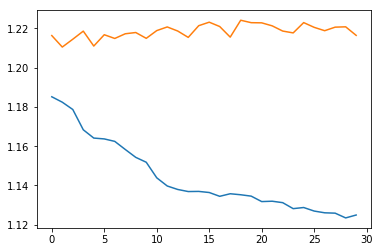

Best training loss = 1.123481
Best validation loss = 1.210508


In [12]:
main_rbm(F=5, learning_rate_type='time', learning_rate_k=0.5, stopping=True, momentum=True)

In [ ]:
best_train_loss
best_validation_loss
min(best_train_predictions)
max(best_train_predictions)
min(best_validation_predictions)
max(best_validation_predictions)

In [ ]:
np.shape(posprods)

In [ ]:
vlStats["users"]

In [ ]:
min(vl_r_hat)

In [ ]:
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()